# Final position in variable interval


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier, XGBRegressor, XGBRanker

import sys

sys.path.append("..")

from utils.custom_cvs import VariableTimeSeriesSplit
from utils.visualization import model_test
from utils.custom_scorers import (
    balanced_accuracy_1interval_score,
    mean_absolute_1interval_error,
    balanced_accuracy_1interval_ranker,
    mean_absolute_1interval_ranker,
)

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


First we will do the validation of the model that predicts the final position of each driver at a ±1 interval.


In [2]:
df = pd.read_csv("../assets/data/processed/other_models.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

scorers = [
    make_scorer(balanced_accuracy_1interval_score),
    make_scorer(mean_absolute_1interval_error, greater_is_better=False),
]

scorers_ranker = [
    balanced_accuracy_1interval_ranker,
    mean_absolute_1interval_ranker,
]

X = pd.read_csv("../assets/data/processed/other_models_X.csv")
y = df["positionFinal"]

## XGBClassifier


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...):
CV with make_scorer(balanced_accuracy_1interval_score): 0.36040396682442133
CV with make_scorer(mean_absolute_1interval_error, greater_is_better=False): -3.5844093416837484
              precision    recall  f1-score   support

           0     

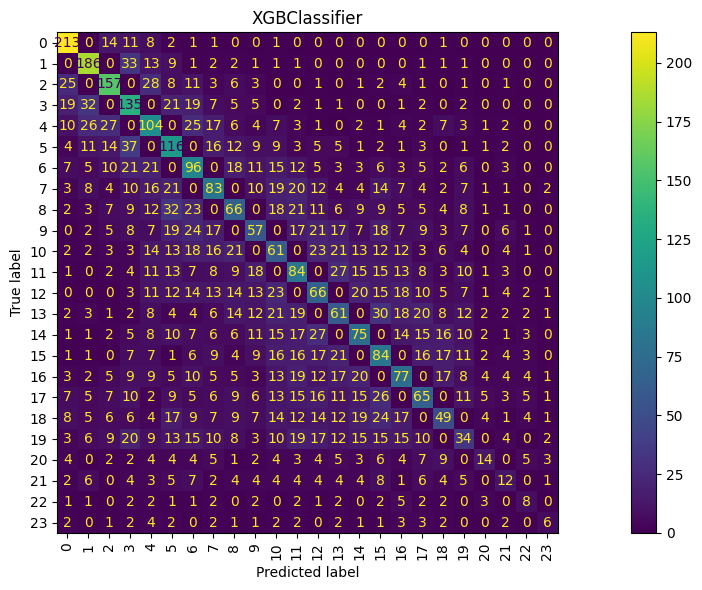

In [3]:
model = XGBClassifier(
    objective="multi:softmax",
    learning_rate=0.1,
    n_estimators=75,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=2,
    reg_lambda=2,
)
model_test((model,), X, y - 1, tscv, scorers=scorers, interval=1)

## XGBRegressor


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...):
CV with make_scorer(balanced_accuracy_1interval_score): 0.2540027312754585
CV with make_scorer(mean_absolute_1interval_error, greater_is_better=False): -3.547542649734385
              precision    recall  f1-score   support

           0       0.94      0.12

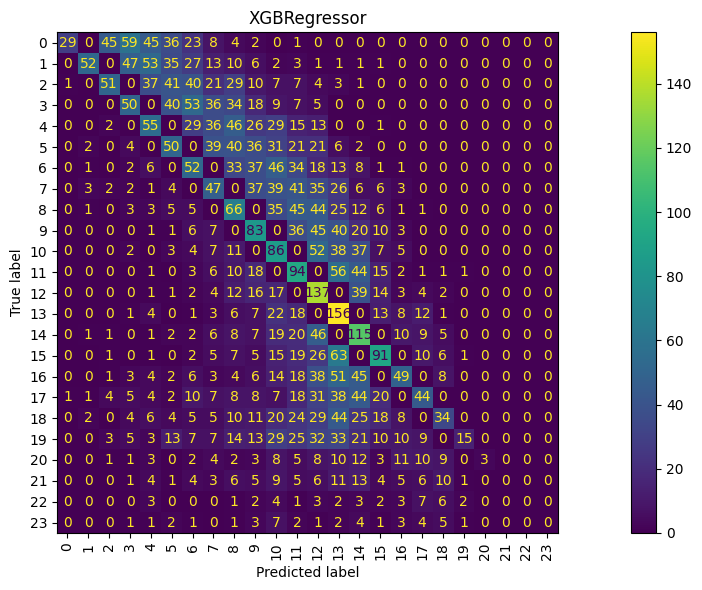

In [4]:
model = XGBRegressor(
    objective="reg:linear",
    learning_rate=0.1,
    n_estimators=75,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=2,
    reg_lambda=2,
)
model_test((model,), X, y - 1, tscv, scorers=scorers, interval=1)

## XGBRanker


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.75, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=3, max_leaves=None, min_child_weight=1,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=75, n_jobs=None, num_parallel_tree=None,
          objective='rank:pairwise', ...):
CV with balanced_accuracy_1interval_ranker: 0.3397589153270972
CV with mean_absolute_1interval_ranker: -3.4710498298532872
              precision    recall  f1-score   support

           1       0.78      0.81      0.80       252
           2       0.68      0.68      0.68       252
           3 

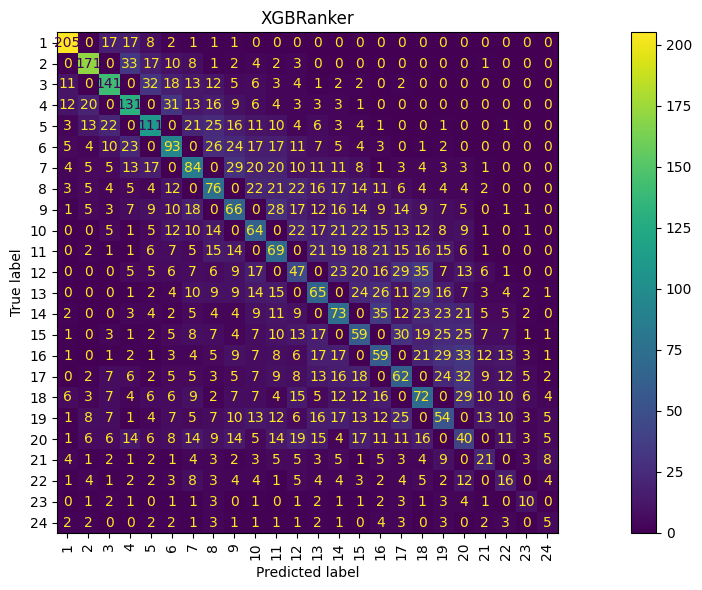

In [5]:
model = XGBRanker(
    objective="rank:pairwise",
    learning_rate=0.1,
    n_estimators=75,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=2,
    reg_lambda=2,
)
model_test(
    (model,),
    X,
    y,
    tscv,
    scorers=scorers_ranker,
    interval=1,
    rank=True,
    multiclass=True,
)

## Results


They do not improve the results, but they match it even without optimizing.
